In [77]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [78]:
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort = True).reset_index(drop=True)
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [79]:
import os

def load_titanic_data(titanic_path =r'D:\machine learning\datasets\titanic',filename = 'train.csv'):
    csv_train_path = os.path.join(titanic_path, filename)
    print(csv_train_path)
    return pd.read_csv(csv_train_path)
df_train = load_titanic_data()
df_test = load_titanic_data(filename='test.csv')

D:\machine learning\datasets\titanic\train.csv
D:\machine learning\datasets\titanic\test.csv


In [80]:
df_all = concat_df(df_train, df_test)

In [81]:
df_all.shape

(1309, 12)

In [82]:
df_all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [83]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [84]:

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [85]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [86]:
df_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,NaN,S
108,109,0,3,"Rekic, Mr. Tido",male,38.0,0,0,349249,7.8958,NaN,S
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C


In [87]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [88]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

In [89]:
df_all.groupby(['Sex', 'Pclass']).median()['Age']

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [90]:
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [91]:
df_all['Age'].isnull().sum()

0

In [92]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [93]:
df_all['Embarked'].isnull().sum()

0

In [94]:
df_all.loc[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [95]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

In [96]:
df_all.isnull().sum()

Age               0
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [97]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [98]:
df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()
df_all_decks

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

In [99]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

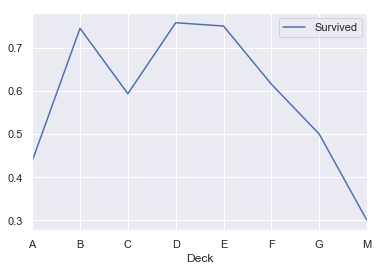

In [100]:
df_all[['Deck','Survived']].groupby(['Deck']).mean().plot()

In [101]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [102]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Deck           1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 133.0+ KB


In [103]:
df_all = df_all.drop("Cabin",axis = 1)

In [104]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1309 non-null float64
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Deck           1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [105]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

In [106]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

In [107]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

In [108]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)


In [109]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

In [110]:
df_all.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,Family_Size,Family_Size_Grouped,Ticket_Frequency
0,"(21.0, 22.0]",S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M,2,Small,1
1,"(34.0, 40.0]",C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,ABC,2,Small,2
2,"(25.0, 26.0]",S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M,1,Alone,1
3,"(34.0, 40.0]",S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,ABC,2,Small,2
4,"(34.0, 40.0]",S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M,1,Alone,1


In [111]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

In [112]:
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')


In [113]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

In [114]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [115]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [116]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

In [117]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [118]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [119]:
df_all = concat_df(df_train, df_test)

In [120]:
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


In [121]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


In [122]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

In [123]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 1 OOB Score: 0.8553370786516854

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 2 OOB Score: 0.844319775596073

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 3 OOB Score: 0.8513323983169705

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    0.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 4 OOB Score: 0.8359046283309958

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 5 OOB Score: 0.8260869565217391

Average OOB Score: 0.8425961674834928


In [124]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions5.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0
